In [73]:
!pip install gym-trading-env

Exception ignored in: <function Socket.__del__ at 0x0000028A2B308DC0>
Traceback (most recent call last):
  File "c:\Users\cleme\miniconda3\lib\site-packages\zmq\sugar\socket.py", line 112, in __del__
    warn(
Exception ignored in: <_io.FileIO name=5 mode='wb' closefd=True>
Traceback (most recent call last):
  File "c:\Users\cleme\miniconda3\lib\site-packages\IPython\utils\_process_win32.py", line 124, in system
    return process_handler(cmd, _system_body)
Exception ignored in: <_io.FileIO name=6 mode='rb' closefd=True>
Traceback (most recent call last):
  File "c:\Users\cleme\miniconda3\lib\site-packages\IPython\utils\_process_win32.py", line 124, in system
    return process_handler(cmd, _system_body)
Exception ignored in: <_io.FileIO name=7 mode='rb' closefd=True>
Traceback (most recent call last):
  File "c:\Users\cleme\miniconda3\lib\site-packages\IPython\utils\_process_win32.py", line 124, in system
    return process_handler(cmd, _system_body)


In [6]:
import numpy as np
import matplotlib.pyplot as plt

from rainbow.agent import Rainbow
from gym_trading_env.environments import MultiDatasetTradingEnv

In [7]:
def add_features(df):
    df["feature_close"] = df["close"].pct_change()
    df["feature_open"] = df["open"]/df["close"]
    df["feature_high"] = df["high"]/df["close"]
    df["feature_low"] = df["low"]/df["close"]
    df["feature_volume"] = df["volume"] / df["volume"].rolling(7*24).max()
    df.dropna(inplace= True) # Clean your data !
    return df

def reward_function(history):
    return 18*np.log(history["portfolio_valuation", -1] / history["portfolio_valuation", -2]) #log (p_t / p_t-1 )

env = MultiDatasetTradingEnv(
        dataset_dir= "data/processed/*.pkl",
        preprocess= add_features,
        windows= None,
        positions = [ -1, -0.5, 0, 0.5, 1], # From -1 (=SHORT), to +1 (=LONG)
        initial_position = 0,
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (= 1h here)
        reward_function = reward_function,
        portfolio_initial_value = 1000, # here, in USDT
    )

In [8]:
agent = Rainbow(
    #Distributional
    distributional= True,
    v_min= -200,
    v_max = 200,
    nb_atoms= 51, 
    # Prioritized Replay
    prioritized_replay =True,
    prioritized_replay_alpha= 0.5,
    prioritized_replay_beta_function = lambda episode, step : min(1, 0.5 + 0.5*step/500_000),
    # General
    multi_steps = 3,
    nb_states = env.observation_space["features"].shape[0] + 1,
    nb_actions = env.action_space.n,
    gamma = 0.99,
    replay_capacity = 1E6,
    tau = 3000,
    
    # Model
    window= 10,
    units = [64,64],
    dropout= 0,
    adversarial= False,
    noisy= False,
    learning_rate = 1E-3,

    batch_size= 64,
    train_every = 4,
    epsilon_function = lambda episode, step : max(0.01, (1 - 1E-5)** step), #lambda episode, step : max(0.05, 0.9999 ** step), # Ignore if noisy is True
    name = "Rainbow",
)

In [2]:
def log(history):
    market_return = history["data_close", -1] / history["data_close", 0] -1
    portfolio_return = history["portfolio_valuation", -1] / history["portfolio_valuation", 0] -1
    sharpe_ratio = (portfolio_return - 0.04) / np.std(history["portfolio_valuation"])
    nb_positions = (history["position"].diff(axis=0) != 0).sum(axis=0)
    print(f"""\
Market Return : {100*market_return:5.2f}%   |   Portfolio Return : {100*portfolio_return:5.2f}%   |   Sharpe Ratio : {sharpe_ratio:4.2f}%   |   Positions : {nb_positions:3d} \
""")

In [3]:
for _ in range(100):
    obs, info = env.reset()
    obs_inputs = np.concatenate([obs["features"], [obs["position"]]])

    done, truncated = False, False
    while not done and not truncated:
        action = agent.e_greedy_pick_action_or_random(obs_inputs)

        next_obs, reward, done, truncated, info = env.step(action)
        next_obs_inputs = np.concatenate([next_obs["features"], [next_obs["position"]]])


        if done or truncated:
            log(env.historical_info)

        agent.store_replay(obs_inputs, action, reward, next_obs_inputs, done, truncated)
        agent.train()
        obs_inputs = next_obs_inputs

NameError: name 'env' is not defined

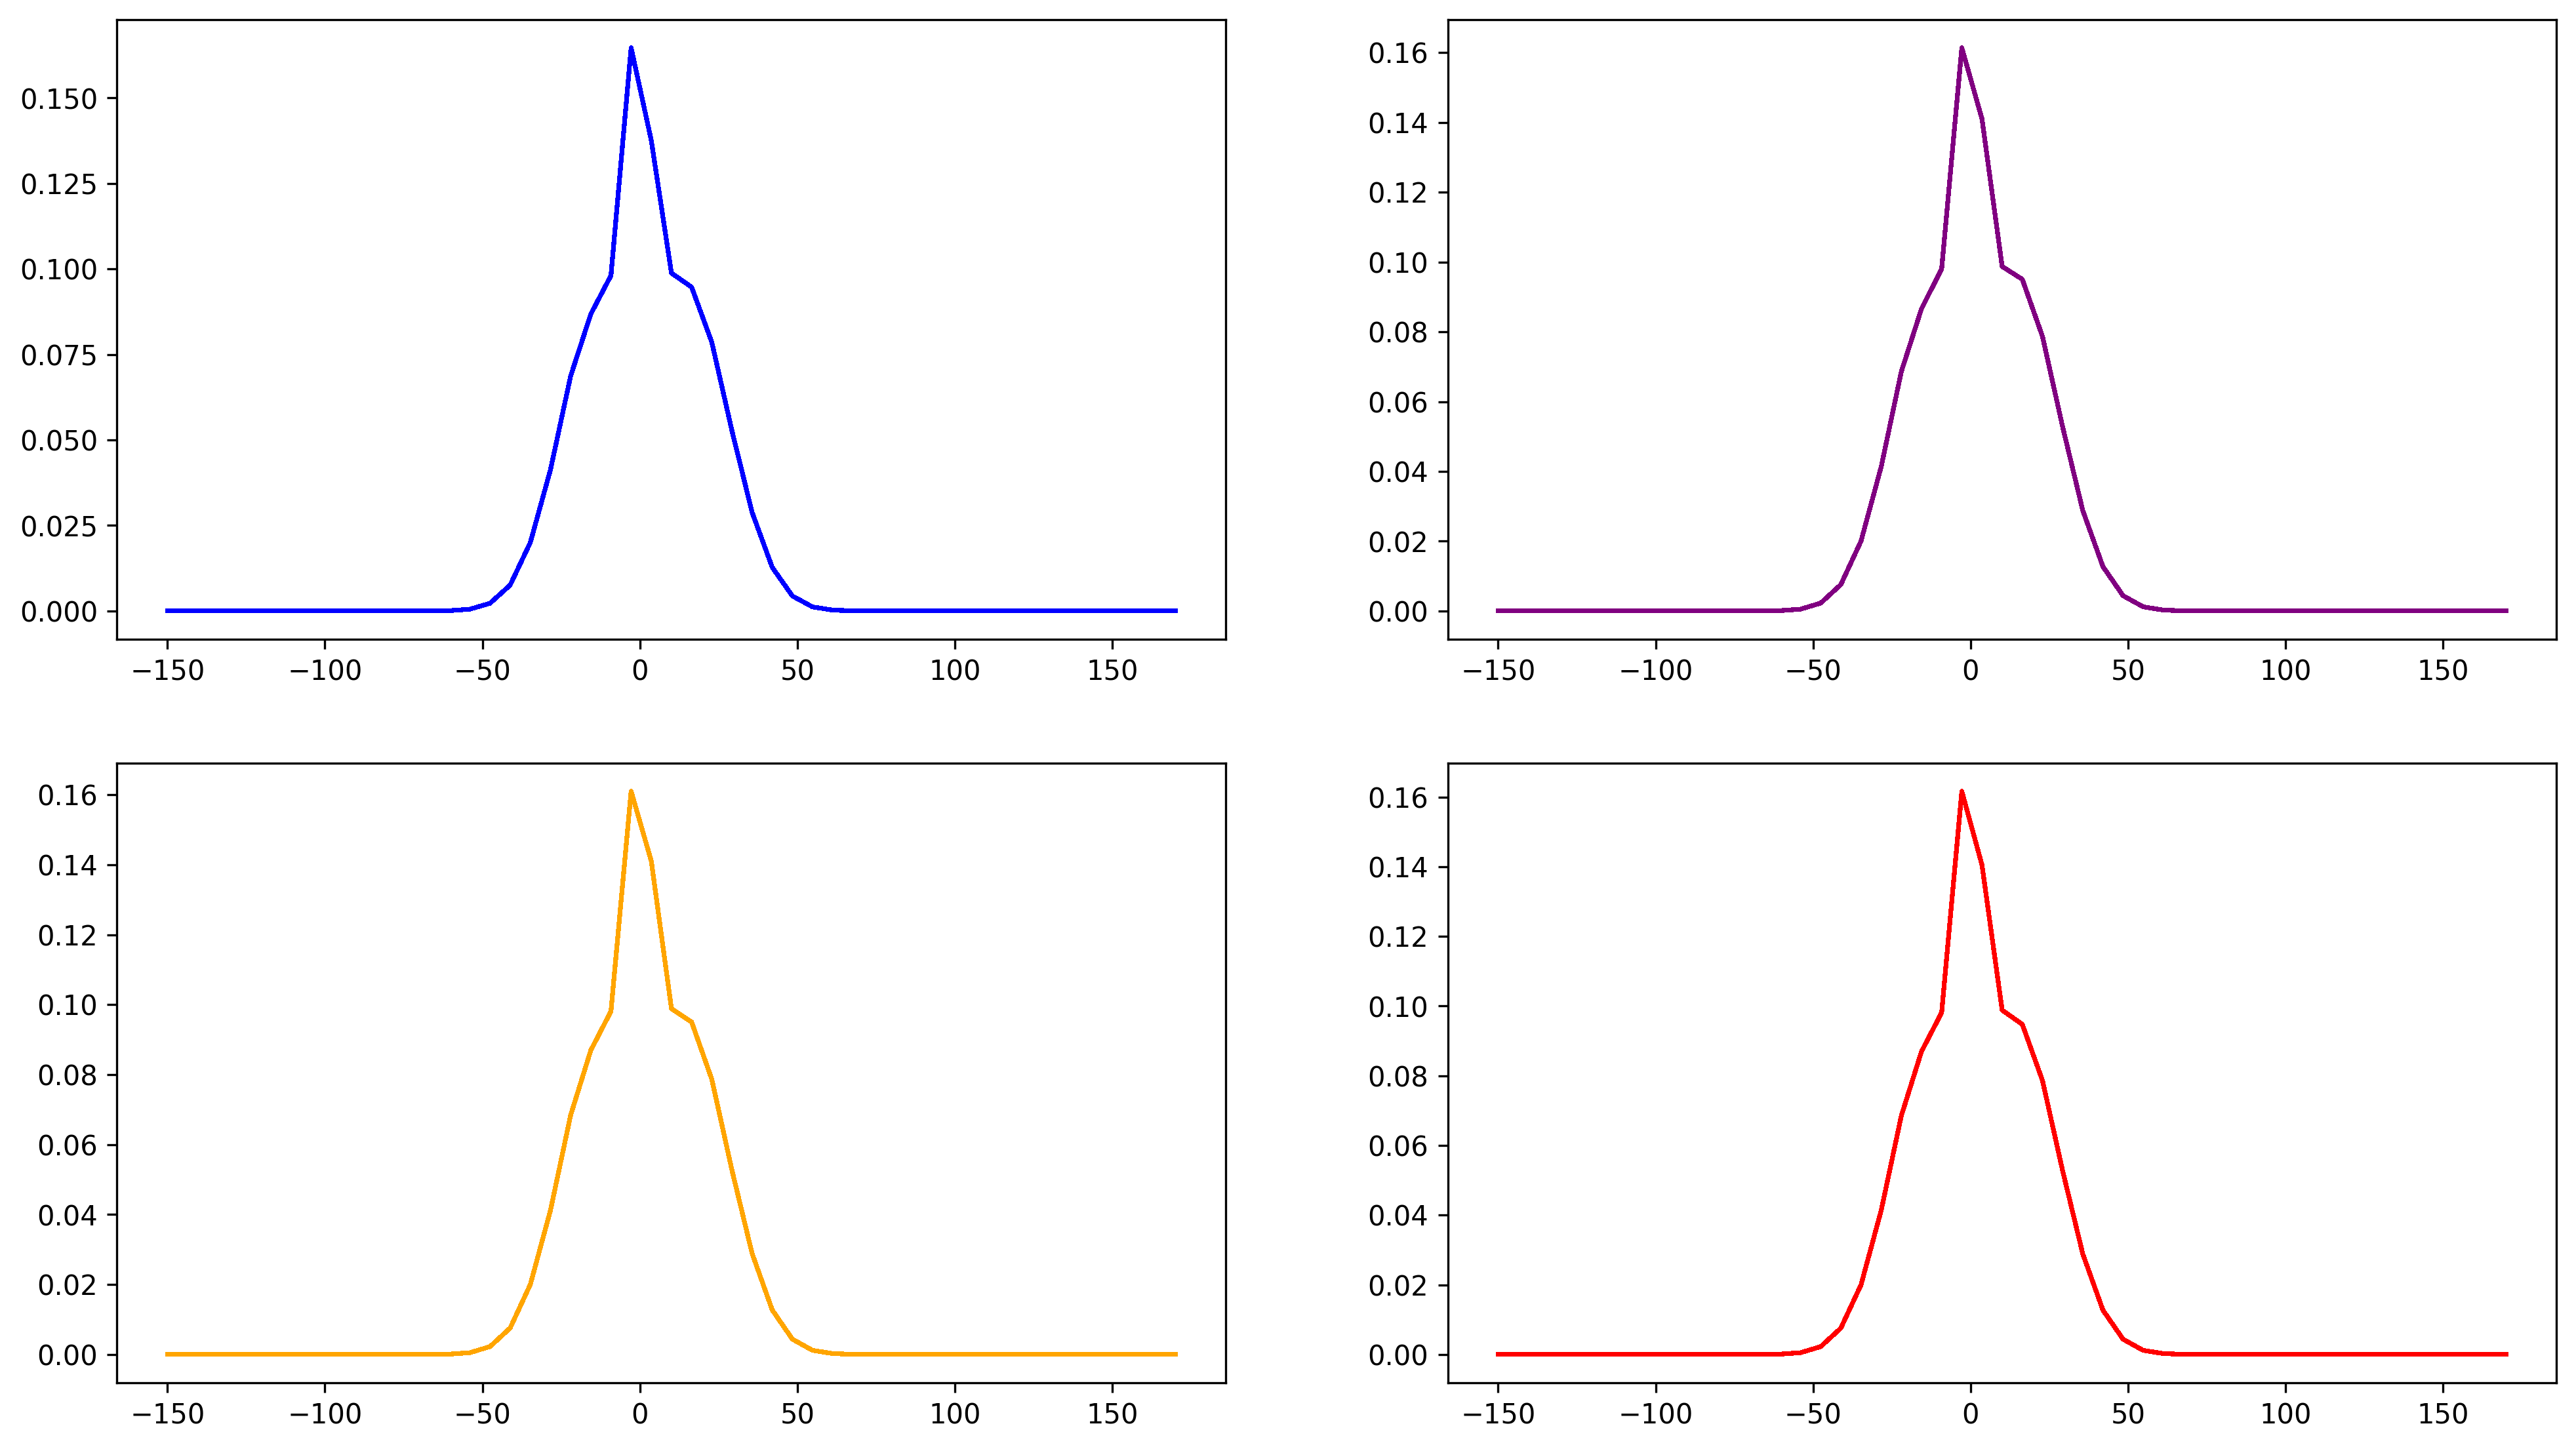

In [83]:
batch_indexes, states, actions, rewards, states_prime, dones, importance_weights = agent.replay_memory.sample(
    1024,
    agent.prioritized_replay_beta_function(agent.episode_count, agent.steps)
)
results = agent.model(states)

action_colors=["blue", "orange","purple","red"]
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,9), dpi=300)
for action in range(4):
    for i in range(256):
        axes[action%2, action//2%2].plot(agent.zs, results[i, action, :], color = action_colors[action], alpha = 0.2)